In [1]:
import pandas as pd
import numpy as np
from gurobipy import *
from multidict import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
xl = pd.ExcelFile('SC2x_W3L1_MPS_FPHV1.xlsx')

In [3]:
xl.sheet_names

['MPS_clean',
 'MPS_level',
 'MPSchase',
 'QGyros_Data',
 'QG_1TR',
 'QG_L4L',
 'QG_FOQ',
 'QG_POQ',
 'QG_SM',
 'QG_WW',
 'MIP']

In [4]:
mps= xl.parse('MPS_clean',index_col=0,skiprows=3,usecols='B:I')
mps = mps.transpose()
mps

Time Period,Forecast,Production Plan,Projected Available Balance
0,NaN,NaN,30.0
1,10.0,NaN,NaN
2,15.0,NaN,NaN
3,20.0,NaN,NaN
4,22.0,NaN,NaN
5,25.0,NaN,NaN
6,28.0,NaN,NaN


In [5]:
# x = [120,130,100,150] #demand for periods
# abt = 10 #available balance today

# x=np.array(x,dtype=float)
# x = np.insert(x,0,np.nan)
# print(x)
# mps = pd.DataFrame({'Time Period':np.arange(0,len(x)),'Forecast': x,'Production Plan':np.nan,'Projected Available Balance':np.nan})
# mps.loc[0,'Projected Available Balance'] = abt
# mps.set_index('Time Period',inplace=True)

                                0     1     2     3     4     5     6
Time Period                                                          
Forecast                      NaN  10.0  15.0  20.0  22.0  25.0  28.0
Production Plan               NaN  20.0  20.0  20.0  20.0  20.0  20.0
Projected Available Balance  30.0  40.0  45.0  45.0  43.0  38.0  30.0


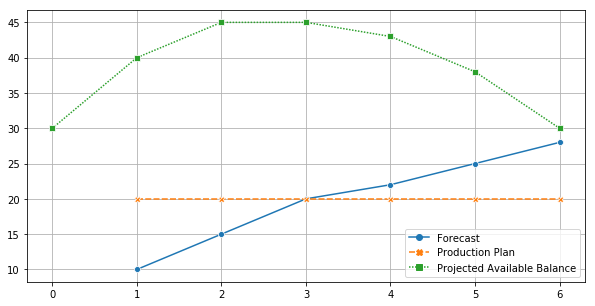

In [6]:
mpsls = mps
mpsls.loc[1:,'Production Plan']=mpsls['Forecast'].sum()/(mpsls.shape[0]-1)
#mpsls.loc[1:,'Production Plan'] = 15
for i in range((mpsls.shape[0]-1)):
    mpsls.loc[i+1,'Projected Available Balance']=mpsls.loc[i,'Projected Available Balance'] +mpsls.loc[i+1,'Production Plan']-mpsls.loc[i+1,'Forecast']

fig,ax= plt.subplots(figsize=(10,5))
plt.grid()
sns.lineplot(data=mpsls,ax=ax,markers=True)
print(mpsls.transpose())

,0,1,2,3,4,5,6
Time Period,,,,,,,
Forecast,NaN,10.0,15.0,20.0,22.0,25.0,28.0
Production Plan,NaN,0.0,0.0,20.0,22.0,25.0,28.0
Projected Available Balance,30.0,20.0,5.0,5.0,5.0,5.0,5.0


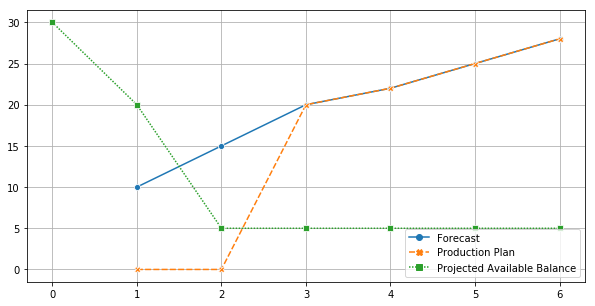

In [7]:
mpsc = mps
for i in range((mpsls.shape[0]-1)):
    if (mpsc.loc[i,'Projected Available Balance']-mpsc.loc[i+1,'Forecast']) >=0:
        mpsc.loc[i+1,'Production Plan'] = 0
    else:
        mpsc.loc[i+1,'Production Plan'] = mpsc.loc[i+1,'Forecast']
    mpsc.loc[i+1,'Projected Available Balance']=mpsc.loc[i,'Projected Available Balance'] +mpsc.loc[i+1,'Production Plan']-mpsc.loc[i+1,'Forecast']
fig,ax= plt.subplots(figsize=(10,5))
plt.grid()
sns.lineplot(data=mpsc,ax=ax,markers=True)
mpsc.transpose()

In [8]:
ct = 500
c = 50
n = 12
h = .24 # $/$/yr
ce = .24*c/n
fph = xl.parse('QGyros_Data',usecols='B:C',skiprows=2,nrows=12,index_col=0)
fph.rename(columns={'Demand':'Forecast'}, inplace=True)
fph

,Forecast
Month,
1,200
2,150
3,100
4,50
5,50
6,100
7,150
8,200
9,200


In [9]:
# x = [120,130,100,150]
# ct = 600
# ce = 5
# n = 1
# fph = pd.DataFrame({'Period':np.arange(1,len(x)+1),'Forecast':x})
# fph.set_index('Period',inplace=True)
# fph = fph.astype(float)

# fph.shape

,Forecast,Production,IOH,Holding Cost,Set-Up Costs,Total Cost
1,200.0,2000.0,1800.0,1800.0,500.0,2300.0
2,150.0,0.0,1650.0,1650.0,0.0,1650.0
3,100.0,0.0,1550.0,1550.0,0.0,1550.0
4,50.0,0.0,1500.0,1500.0,0.0,1500.0
5,50.0,0.0,1450.0,1450.0,0.0,1450.0
6,100.0,0.0,1350.0,1350.0,0.0,1350.0
7,150.0,0.0,1200.0,1200.0,0.0,1200.0
8,200.0,0.0,1000.0,1000.0,0.0,1000.0
9,200.0,0.0,800.0,800.0,0.0,800.0
10,250.0,0.0,550.0,550.0,0.0,550.0


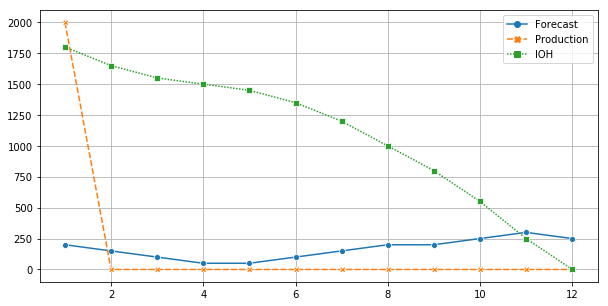

In [10]:
# 1TR

otr = fph.copy()
for i in range(1,(otr.shape[0]+1)):
    if i == 1 :
        otr.loc[i,'Production'] = otr['Forecast'].sum()
        otr.loc[i,'IOH'] = otr.loc[i,'Production'] - otr.loc[i,'Forecast']
    else:
        otr.loc[i,'Production'] = 0
        otr.loc[i,'IOH']=otr.loc[i-1,'IOH'] - otr.loc[i,'Forecast']
        
otr['Holding Cost'] = otr['IOH']*ce
otr.loc[1,'Set-Up Costs'] = ct
otr = otr.fillna(0)
otr['Total Cost'] = otr['Set-Up Costs'] + otr['Holding Cost']


if ('sum' not in otr.index):
    otr = otr.append(otr.agg(['sum', 'mean']))

np.round(otr,2)
fig,ax= plt.subplots(figsize=(10,5))
plt.grid()
sns.lineplot(data=otr.iloc[0:fph.shape[0],0:3],ax=ax,markers=True)
np.round(otr,0)

,Forecast,Production,IOH,Holding Cost,Set-Up Costs,Total Cost
1,200.0,200.0,0.0,0.0,500.0,500.0
2,150.0,150.0,0.0,0.0,500.0,500.0
3,100.0,100.0,0.0,0.0,500.0,500.0
4,50.0,50.0,0.0,0.0,500.0,500.0
5,50.0,50.0,0.0,0.0,500.0,500.0
6,100.0,100.0,0.0,0.0,500.0,500.0
7,150.0,150.0,0.0,0.0,500.0,500.0
8,200.0,200.0,0.0,0.0,500.0,500.0
9,200.0,200.0,0.0,0.0,500.0,500.0
10,250.0,250.0,0.0,0.0,500.0,500.0


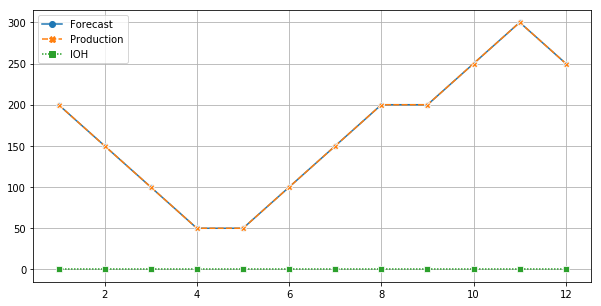

In [11]:
# L4L
l4l = fph.copy().astype(float)
l4l['Production'] = l4l['Forecast']
l4l['IOH'] = l4l['Production'] - l4l['Forecast']
l4l['Holding Cost'] = l4l['IOH']*ce
l4l['Set-Up Costs'] = float(ct)
l4l['Total Cost'] = l4l.apply(lambda x: x['Set-Up Costs']+x['Holding Cost'],axis=1)

if ('sum' not in l4l.index):
    l4l = l4l.append(l4l.agg(['sum', 'mean']))


fig,ax= plt.subplots(figsize=(10,5))
plt.grid()
sns.lineplot(data=l4l.iloc[0:fph.shape[0],0:3],ax=ax,markers=True)


np.round(l4l,0)

In [12]:
FOQ = np.round(np.sqrt(2*ct*fph['Forecast'].sum()/n/(ce)),-2)
FOQ

400.0

,Forecast,Production,IOH,Holding Cost,Set-Up Costs,Total Cost
1,200.0,400.0,200.0,200.0,500.0,700.0
2,150.0,0.0,50.0,50.0,0.0,50.0
3,100.0,400.0,350.0,350.0,500.0,850.0
4,50.0,0.0,300.0,300.0,0.0,300.0
5,50.0,0.0,250.0,250.0,0.0,250.0
6,100.0,0.0,150.0,150.0,0.0,150.0
7,150.0,0.0,0.0,0.0,0.0,0.0
8,200.0,400.0,200.0,200.0,500.0,700.0
9,200.0,0.0,0.0,0.0,0.0,0.0
10,250.0,400.0,150.0,150.0,500.0,650.0


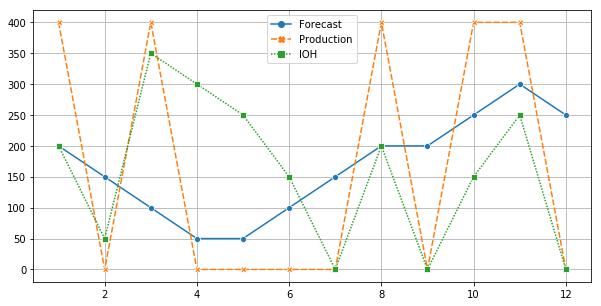

In [13]:
# FOQ
foq = fph.copy().astype(float)
FOQ = np.round(np.sqrt(2*ct*fph['Forecast'].sum()/n/(ce)),-2)
#FOQ = 250
for i in range(1,(foq.shape[0]+1)):
    if i == 1 :
        foq.loc[i,'Production'] = FOQ
        foq.loc[i,'IOH'] = foq.loc[i,'Production'] - foq.loc[i,'Forecast']
        foq.loc[i,'Holding Cost'] = foq.loc[i,'IOH']*ce
        foq.loc[i,'Set-Up Costs'] = ct
    else:
        if (foq.loc[i,'Forecast']>foq.loc[i-1,'IOH']):
            foq.loc[i,'Production'] = FOQ
            foq.loc[i,'Set-Up Costs'] = ct
        else:
            foq.loc[i,'Production'] =  0
        foq.loc[i,'IOH']=foq.loc[i-1,'IOH'] + foq.loc[i,'Production'] - foq.loc[i,'Forecast']
        

foq['Holding Cost'] = foq['IOH']*ce
foq = foq.fillna(0)
foq['Total Cost'] = foq['Set-Up Costs'] + foq['Holding Cost']


if ('sum' not in foq.index):
    foq = foq.append(foq.agg(['sum', 'mean']))


fig,ax= plt.subplots(figsize=(10,5))
plt.grid()
sns.lineplot(data=foq.iloc[0:fph.shape[0],0:3],ax=ax,markers=True)
np.round(foq,0)

,Forecast,Production,IOH,Holding Cost,Set-Up Costs,Total Cost
1,200.0,450.0,250.0,250.0,500.0,750.0
2,150.0,0.0,100.0,100.0,0.0,100.0
3,100.0,0.0,0.0,0.0,0.0,0.0
4,50.0,200.0,150.0,150.0,500.0,650.0
5,50.0,0.0,100.0,100.0,0.0,100.0
6,100.0,0.0,0.0,0.0,0.0,0.0
7,150.0,550.0,400.0,400.0,500.0,900.0
8,200.0,0.0,200.0,200.0,0.0,200.0
9,200.0,0.0,0.0,0.0,0.0,0.0
10,250.0,800.0,550.0,550.0,500.0,1050.0


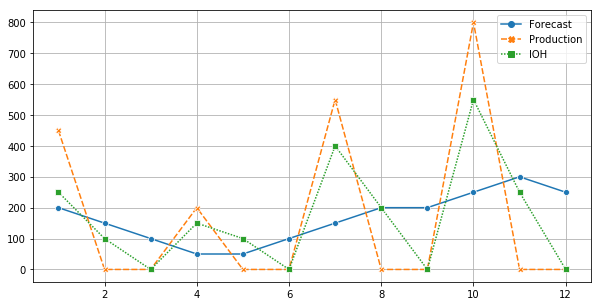

In [14]:
# POQ
poq = fph.copy().astype(float)
T = int(np.ceil(FOQ/2000*12))
#poq = 500
for i in range(1,(poq.shape[0]+1)):
    if (((i-1)%T)==0) :
        poq.loc[i,'Production'] = poq.iloc[(i-1):(i+T-1),0].sum()
        poq.loc[i,'IOH'] = poq.loc[i,'Production'] - poq.loc[i,'Forecast']
        poq.loc[i,'Holding Cost'] = poq.loc[i,'IOH']*ce
        poq.loc[i,'Set-Up Costs'] = ct
    else:
        poq.loc[i,'Production'] = 0
        poq.loc[i,'IOH']=poq.loc[i-1,'IOH'] + poq.loc[i,'Production'] - poq.loc[i,'Forecast']
        poq.loc[i,'Set-Up Costs'] = 0
    
    
        
        

poq['Holding Cost'] = poq['IOH']*ce
poq = poq.fillna(0)
poq['Total Cost'] = poq['Set-Up Costs'] + poq['Holding Cost']


if ('sum' not in poq.index):
    poq = poq.append(poq.agg(['sum', 'mean']))


fig,ax= plt.subplots(figsize=(10,5))
plt.grid()
sns.lineplot(data=poq.iloc[0:fph.shape[0],0:3],ax=ax,markers=True)
np.round(poq,0)

In [15]:
# from https://github.com/lmarkely/scanalytics

def MPS_silvermeal(demand_forecast,setup_cost,holding_cost,init_inventory):
    '''
    MPS using Silver Meal strategy.
    argument:
    demand_forecast (list): demand for each time period
    setup_cost (float): fixed cost of setting up manufacturing
    holding_cost (float): fixed cost of init_inventory
    init_inventory(float): initial inventory
    output:
    inventory (list): inventory for each time period
    quantity (list): quantity of product manufactured for each time period
    total_cost (float): total cost of manufacturing and inventory
    '''

    prod_schedule = []
    inventory = []

    #First check how many time period the current inventory can hold
    init_prod = 0
    while init_prod in range(len(demand_forecast)):
        if np.sum(demand_forecast[:init_prod + 1]) <= init_inventory:
            init_prod += 1
        else: break

    #Add 0 as the production during this period of using current inventory
    for idx in range(init_prod):
        if idx == 0:
            prod_schedule.append(0)
            inventory.append(init_inventory - demand_forecast[idx])
        else:
            prod_schedule.append(0)
            inventory.append(inventory[idx-1] - demand_forecast[idx])

    ix = init_prod

    while ix in range(init_prod,len(demand_forecast)):
        cost = setup_cost
        if ix+1 == len(demand_forecast):
            prod_schedule.append(demand_forecast[ix])
            inventory.append(0)
            break
        next_cost = (setup_cost + demand_forecast[ix+1]*holding_cost)/2
        inventory_factor = [1*holding_cost]
        ix2 = 1
        while next_cost <= cost and ix+ix2 < len(demand_forecast):
            cost = next_cost
            ix2 += 1
            inventory_factor.append(ix2*holding_cost)
            next_cost = ((setup_cost + sum(i[0] * i[1]
                         for i in zip(demand_forecast[ix+1:ix+ix2+1],inventory_factor)))/(1+ix2))
        ix += ix2
        if not inventory:
            production = sum(demand_forecast[ix-ix2:ix])
            inventory.append(production-demand_forecast[ix-ix2])
        else:
            production = sum(demand_forecast[ix-ix2:ix])-inventory[-1]
            inventory.append(inventory[-1]+production-demand_forecast[ix-ix2])

        prod_schedule.append(production)

        for i in range(ix2-1):
            prod_schedule.append(0)
            inventory.append(inventory[-1]-demand_forecast[ix-ix2+i+1])

    total_setup_cost = 0
    for i in prod_schedule:
        if i > 0: total_setup_cost += setup_cost

    total_holding_cost = 0
    for i in inventory:
        if i > 0: total_holding_cost += i*holding_cost

    total_cost = total_setup_cost + total_holding_cost

    return inventory,prod_schedule,total_cost

,Forecast,Production,IOH,Holding Cost,Set-Up Costs,Total Cost
1,200.0,550.0,350.0,350.0,500.0,850.0
2,150.0,0.0,200.0,200.0,0.0,200.0
3,100.0,0.0,100.0,100.0,0.0,100.0
4,50.0,0.0,50.0,50.0,0.0,50.0
5,50.0,0.0,0.0,0.0,0.0,0.0
6,100.0,250.0,150.0,150.0,500.0,650.0
7,150.0,0.0,0.0,0.0,0.0,0.0
8,200.0,400.0,200.0,200.0,500.0,700.0
9,200.0,0.0,0.0,0.0,0.0,0.0
10,250.0,550.0,300.0,300.0,500.0,800.0


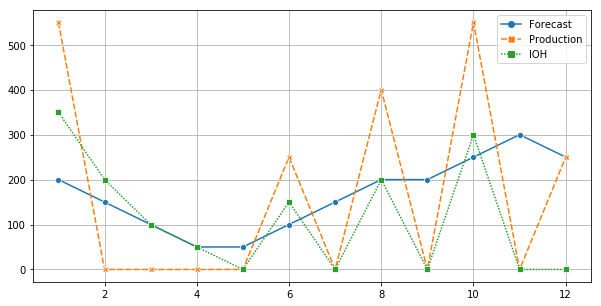

In [16]:
# Silver-Meal (LCP)

sm = fph.copy().astype(float)

demand_forecast = list(sm['Forecast'])
setup_cost = ct
holding_cost = ce
init_inventory = 0
inventory,prod_schedule,total_cost = MPS_silvermeal(demand_forecast,setup_cost,holding_cost,init_inventory)
sm['Production'] = prod_schedule
sm['IOH'] = inventory
sm['Holding Cost'] = sm['IOH']*ce
sm['Set-Up Costs'] = sm.apply(lambda x: ct if x['Production']>0 else 0,axis=1)
sm['Total Cost'] = sm['Holding Cost'] + sm['Set-Up Costs']

if ('sum' not in sm.index):
    sm = sm.append(sm.agg(['sum', 'mean']))


fig,ax= plt.subplots(figsize=(10,5))
plt.grid()
sns.lineplot(data=sm.iloc[0:fph.shape[0],0:3],ax=ax,markers=True)
np.round(sm,0)

In [17]:
# from https://github.com/ichigooo/wagner-whitin/blob/master/README.md
def wagner_whitin(K, h, demand):
    """
    K:@float, the fixed ordering cost.
    h:@float, the holding cost.
    demand:@list[float], an array of demand for each period.
    return
    F:@float, optimal total fixed ordering and holding costs.
    order:@list[float], optimal number of purchase at each period.
    """

    order = [] # optimal order of purchase at each period
    demand = np.array(demand)
    n = len(demand)
    print ("n: ", n)
    cost = [[0 for i in range(0,n)] for j in range(0, n)]
    # print (cost)
    for i in range(0, n):
        for j in range(i , n):
            cost[i][j] += K
            for k in range(i + 1, (j + 1)):
                # print ("demand: ", k, "holding days: ", k - i)
                cost[i][j] += h * (k - i) * demand[k]
    print ("==========================constructing cost matrix==========================")
    print ("cost matrix: ", cost)

    #  initializing the optimal order cost within the period i, j
    F = [[0 for i in range(0,n)] for j in range(0, n)]
    order_m = [[[j] for i in range(0,n)] for j in range(0, n)]

    print ("==========================constructing total cost matrix==========================")
    for j in range(0, n):
        for i in range(0, j+1):
            print ("Fij: ", j - i, j)
            F[j - i][j] = cost[j - i][j]
            for k in range(j - i, j):
                if (cost[j - i][k] + F[k+1][j] < F[j - i][j]):
                    F[j - i][j] = cost[j - i][k] + F[k+1][j]
                    order_m[j - i][j] = [j - i, k+1]
                    # order[j - i] = sum(demand[j - i: k + 1])
                    # for m in range(j - i + 1, k + 1):
                    # 	order[m] = 0
                    print ("costik + Fk+1j: cost", j - i, k, "  + F", k + 1, j, " is smaller, order at period ", k+1)
    print ("F: ", F)
    # print ("order_m: ", order_m)

    optimal = F[0][len(F) - 1]

    order_periods = find_order_periods(order_m, len(demand))
    order = get_order_amount(order_periods, demand)

    print ("==========================optimal answer==========================")
    print ("optimal: ", optimal)
    # print ("order in the following periods: ", order_periods)
    print ("order amount for each period: ", order)

    return optimal, order
#  get the periods which needs to order
def find_order_periods(order_matrix, n):
	order_periods = []
	order_periods.append(0)
	next = order_matrix[0][n - 1][1]
	order_periods.append(next)
	while(len(order_matrix[next][n - 1]) == 2):
		order_periods.append(order_matrix[next][n - 1][1])
		next = order_matrix[next][n - 1][1]
	return order_periods


def get_order_amount(order_periods, demand):
	order = [0 for i in range(0, len(demand))]
	for i, num in enumerate(order_periods):
		order[num] = sum(demand[num:order_periods[i+1]]) if (i + 1 < len(order_periods)) else sum(demand[num:len(demand)])
	return order

In [18]:
ww = fph.copy().astype(float)

optimal,order = wagner_whitin(ct,ce,list(ww['Forecast']))


n:  12
==========================constructing cost matrix==========================
cost matrix:  [[500, 650.0, 850.0, 1000.0, 1200.0, 1700.0, 2600.0, 4000.0, 5600.0, 7850.0, 10850.0, 13600.0], [0, 500, 600.0, 700.0, 850.0, 1250.0, 2000.0, 3200.0, 4600.0, 6600.0, 9300.0, 11800.0], [0, 0, 500, 550.0, 650.0, 950.0, 1550.0, 2550.0, 3750.0, 5500.0, 7900.0, 10150.0], [0, 0, 0, 500, 550.0, 750.0, 1200.0, 2000.0, 3000.0, 4500.0, 6600.0, 8600.0], [0, 0, 0, 0, 500, 600.0, 900.0, 1500.0, 2300.0, 3550.0, 5350.0, 7100.0], [0, 0, 0, 0, 0, 500, 650.0, 1050.0, 1650.0, 2650.0, 4150.0, 5650.0], [0, 0, 0, 0, 0, 0, 500, 700.0, 1100.0, 1850.0, 3050.0, 4300.0], [0, 0, 0, 0, 0, 0, 0, 500, 700.0, 1200.0, 2100.0, 3100.0], [0, 0, 0, 0, 0, 0, 0, 0, 500, 750.0, 1350.0, 2100.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 800.0, 1300.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 750.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500]]
==========================constructing total cost matrix==========================
Fij:  0 0
Fij:  1 1
Fi

,Forecast,Production,IOH,Holding Cost,Set-Up Costs,Total Cost
1,200.0,550.0,350.0,350.0,500.0,850.0
2,150.0,0.0,200.0,200.0,0.0,200.0
3,100.0,0.0,100.0,100.0,0.0,100.0
4,50.0,0.0,50.0,50.0,0.0,50.0
5,50.0,0.0,0.0,0.0,0.0,0.0
6,100.0,450.0,350.0,350.0,500.0,850.0
7,150.0,0.0,200.0,200.0,0.0,200.0
8,200.0,0.0,0.0,0.0,0.0,0.0
9,200.0,450.0,250.0,250.0,500.0,750.0
10,250.0,0.0,0.0,0.0,0.0,0.0


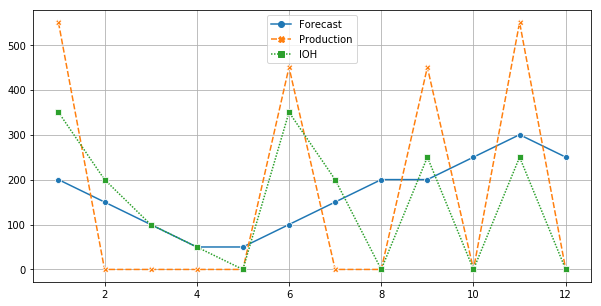

In [19]:
for i in range(1,len(fph)+1):
    ww.loc[i,'Production'] = order[i-1]
    if i == 1:
        ww.loc[1,'IOH'] = ww.loc[1,'Production']-ww.loc[1,'Forecast']
    else:
        ww.loc[i,'IOH'] = ww.loc[i-1,'IOH']-ww.loc[i,'Forecast']+ww.loc[i,'Production']
    
ww['Holding Cost'] = ww['IOH']*ce
ww['Set-Up Costs'] = ww.apply(lambda x: ct if x['Production']>0 else 0,axis=1)
ww['Total Cost'] = ww['Holding Cost'] + ww['Set-Up Costs']

if ('sum' not in ww.index):
    ww = ww.append(ww.agg(['sum', 'mean']))


fig,ax= plt.subplots(figsize=(10,5))
plt.grid()
sns.lineplot(data=ww.iloc[0:fph.shape[0],0:3],ax=ax,markers=True)
np.round(ww,0)

In [22]:
def fph_milp(demand_forecast,setup_cost,holding_cost):
    
    '''MPS using Mixed Integer Linear Programming
    argument:
    demand_forecast (list): demand for each time period
    setup_cost (float): fixed cost of setting up manufacturing
    holding_cost (float): fixed cost of init_inventory
    output:
    status (string): status of mixed integer linear programming
    inventory (list): inventory for each time period
    prod_schedule (list): production schedule for each time period
    total_cost (float): total cost of manufacturing and inventory
    '''

    model = Model('FPH_MILP')
    #Variables
    period = list(np.arange(1,(len(demand_forecast)+1)))
    M = np.sum(demand_forecast)
    
    Q,Z,I= {},{},{}
    I[0] = model.addVar(vtype="C",name="I(0)")
    for p in period:
        Z[p] = model.addVar(vtype="B", name="Z(%s)"%p)
        Q[p] = model.addVar(vtype="C", name="Q(%s)"%p)
        I[p] = model.addVar(vtype="C",name="I(%s)"%p)    
    
    model.addConstr(I[0] == 0, "BegInv")
    
    for p in period:
        model.addConstr((Q[p]-demand_forecast[p]+I[p-1]-I[p])==0,"Link1(%s)"%p)
        model.addConstr((M*Z[p]-Q[p])>=0,"Link2(%s)"%p)
    
    model.setObjective(
        quicksum(setup_cost*Z[p] + holding_cost*I[p] for p in period),
        GRB.MINIMIZE)
    model.update()
    model.__data = Q,Z,I
    return model


Academic license - for non-commercial use only
Optimize a model with 25 rows, 37 columns and 61 nonzeros
Variable types: 25 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+01, 3e+02]
Found heuristic solution: objective 6000.0000000
Presolve removed 4 rows and 5 columns
Presolve time: 0.00s
Presolved: 21 rows, 32 columns, 52 nonzeros
Variable types: 21 continuous, 11 integer (11 binary)

Root relaxation: objective 1.562500e+03, 12 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1562.50000    0    9 6000.00000 1562.50000  74.0%     -    0s
H    0     0                    5750.0000000 1562.50000  72.8%     -    0s
     0     0 2694.20411    0    8 5750.00000 2694.20411  53.1%     -    0s
H    0     0                

,Forecast,Production,IOH,Holding Cost,Set-Up Costs,Total Cost
1,200.0,550.0,350.0,350.0,500.0,850.0
2,150.0,0.0,200.0,200.0,0.0,200.0
3,100.0,0.0,100.0,100.0,0.0,100.0
4,50.0,0.0,50.0,50.0,0.0,50.0
5,50.0,0.0,0.0,0.0,0.0,0.0
6,100.0,450.0,350.0,350.0,500.0,850.0
7,150.0,0.0,200.0,200.0,0.0,200.0
8,200.0,0.0,0.0,0.0,0.0,0.0
9,200.0,450.0,250.0,250.0,500.0,750.0
10,250.0,0.0,0.0,0.0,0.0,0.0


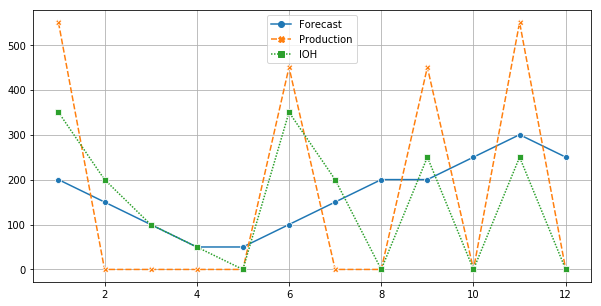

In [23]:

milp = fph.copy().astype(float)

demand_forecast = fph['Forecast']
setup_cost = ct
holding_cost = ce
model = fph_milp(fph['Forecast'],setup_cost,holding_cost)
model.optimize()

Q,Z,I = model.__data

EPS = 1.e-6
milp['Production'] = [np.round(Q[i].X) if Q[i].X > EPS else 0 for i in Q ]
milp['IOH'] = [np.round(I[i].X) if I[i].X > EPS else 0 for i in I ][1:]
milp['Holding Cost'] = milp['IOH']*ce
milp['Set-Up Costs'] = milp.apply(lambda x: ct if x['Production']>0 else 0,axis=1)
milp['Total Cost'] = milp['Holding Cost'] + milp['Set-Up Costs']

if ('sum' not in milp.index):
    milp = milp.append(milp.agg(['sum', 'mean']))


fig,ax= plt.subplots(figsize=(10,5))
plt.grid()
sns.lineplot(data=milp.iloc[0:fph.shape[0],0:3],ax=ax,markers=True)
np.round(milp,0)

In [24]:
dfl = {'One Time Run':otr,'Lot for Lot (Chase)':l4l,'Fixed Order Quantity':foq,'Periodic Order Quantity':poq,
       'Silver-Meal ':sm,'Wagner-Whitin':ww,'MILP':milp}
summary = pd.DataFrame({})
for i,d in dfl.items():
    summary.loc[i,'Inventory Costs'] = (d.loc['sum','Holding Cost'])
    summary.loc[i,'Set-Up Costs'] = (d.loc['sum','Set-Up Costs'])
    summary.loc[i,'Total Costs'] = (d.loc['sum','Total Cost'])
    summary.loc[i,'Avg Monthly IOH'] = (d.loc['mean','IOH'])
    summary.loc[i,'Inventory Turns'] =  (d.loc['sum','Forecast'])/(d.loc['mean','IOH']) 

C:\Users\anzar\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


In [26]:
np.round(summary,2)

,Inventory Costs,Set-Up Costs,Total Costs,Avg Monthly IOH,Inventory Turns
One Time Run,13100.0,500.0,13600.0,1091.67,1.830000
Lot for Lot (Chase),0.0,6000.0,6000.0,0.00,inf
Fixed Order Quantity,1900.0,2500.0,4400.0,158.33,12.630000
Periodic Order Quantity,2000.0,2000.0,4000.0,166.67,12.000000
Silver-Meal,1350.0,2500.0,3850.0,112.50,17.780000
Wagner-Whitin,1750.0,2000.0,3750.0,145.83,13.710000
MILP,1750.0,2000.0,3750.0,145.83,13.710000
